In [3]:
import os, sys
import click

import matplotlib.pyplot as plt
import torch
import seaborn as sns
import pandas as pd
import polars as pl
import dask.array as da
from tqdm import tqdm
from utils.mmap_dataset import MMapIndexedDataset

from dask_jobqueue import SLURMCluster
from dask.distributed import Client
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import polars as pl
from transformers import GPTNeoXForCausalLM, AutoTokenizer
import numpy as np

In [4]:
plt.rcParams['font.size']=20.
plt.rcParams['axes.labelsize']=18.
plt.rcParams['axes.titlesize']=18.
plt.rcParams['legend.fontsize']=18.
plt.rcParams['savefig.dpi']=1000
plt.rcParams['xtick.labelsize']=17.
plt.rcParams['ytick.labelsize']=17.
plt.rcParams['xtick.minor.size']=3
plt.rcParams['xtick.major.size']=5
plt.rcParams['ytick.minor.size']=3
plt.rcParams['ytick.major.size']=5
plt.rcParams['xtick.major.width']=1.
plt.rcParams['xtick.minor.width']=1.
plt.rcParams['ytick.major.width']=1.
plt.rcParams['ytick.minor.width']=1.
plt.rcParams['axes.linewidth']=2.
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.constrained_layout.use'] = True

In [5]:
model_id = '1b-v0'
checkpoint=10000
model = GPTNeoXForCausalLM.from_pretrained(
    f"EleutherAI/pythia-{model_id}",
    use_cache=False,
    revision = f'step{checkpoint}',
    cache_dir=f"/om/user/sunnyd/transformers_cache/"
)

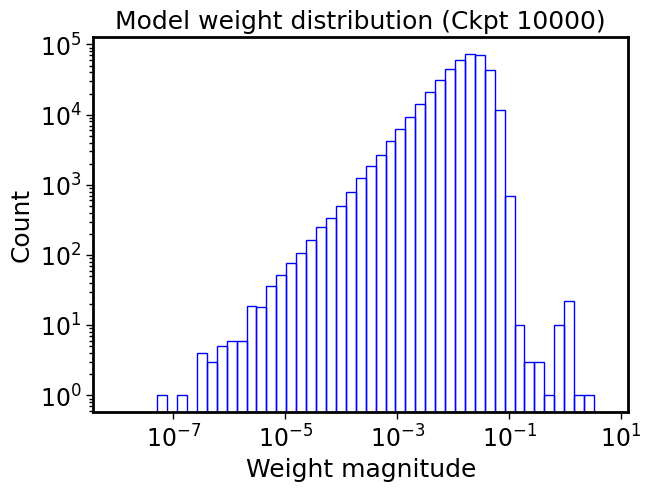

In [65]:
param = dict(model.named_parameters())
all_params = torch.concatenate([x.flatten() for x in param.values()])
x = all_params.detach().numpy()[np.random.choice(len(all_params), 400000)]

f, ax = plt.subplots()
ax.hist(np.abs(x), bins=np.logspace(-8, np.log(2), 50), alpha=1.0, edgecolor='blue', fill=False)
ax.set(yscale='log', xscale='log', title="Model weight distribution (Ckpt 10000)", xlabel = "Weight magnitude", ylabel="Count")

f.savefig('../figures/weight_dist.pdf')

In [10]:
import itertools
ckpts = range(10000, 20000, 1000)
model_id = '1b-v0'
dists = []
for c1, c2 in tqdm(itertools.product(ckpts, ckpts)):
    model = GPTNeoXForCausalLM.from_pretrained(
        f"EleutherAI/pythia-{model_id}",
        use_cache=False,
        revision = f'step{c1}',
        cache_dir=f"/om/user/sunnyd/transformers_cache/"
    )
    param = dict(model.named_parameters())
    p1 = torch.concatenate([x.flatten() for x in param.values()]).detach().numpy()

    model = GPTNeoXForCausalLM.from_pretrained(
        f"EleutherAI/pythia-{model_id}",
        use_cache=False,
        revision = f'step{c2}',
        cache_dir=f"/om/user/sunnyd/transformers_cache/"
    )
    param = dict(model.named_parameters())
    p2 = torch.concatenate([x.flatten() for x in param.values()]).detach().numpy()
    dists.append(np.sum(np.square(p2 - p1)))


100it [05:36,  3.36s/it]


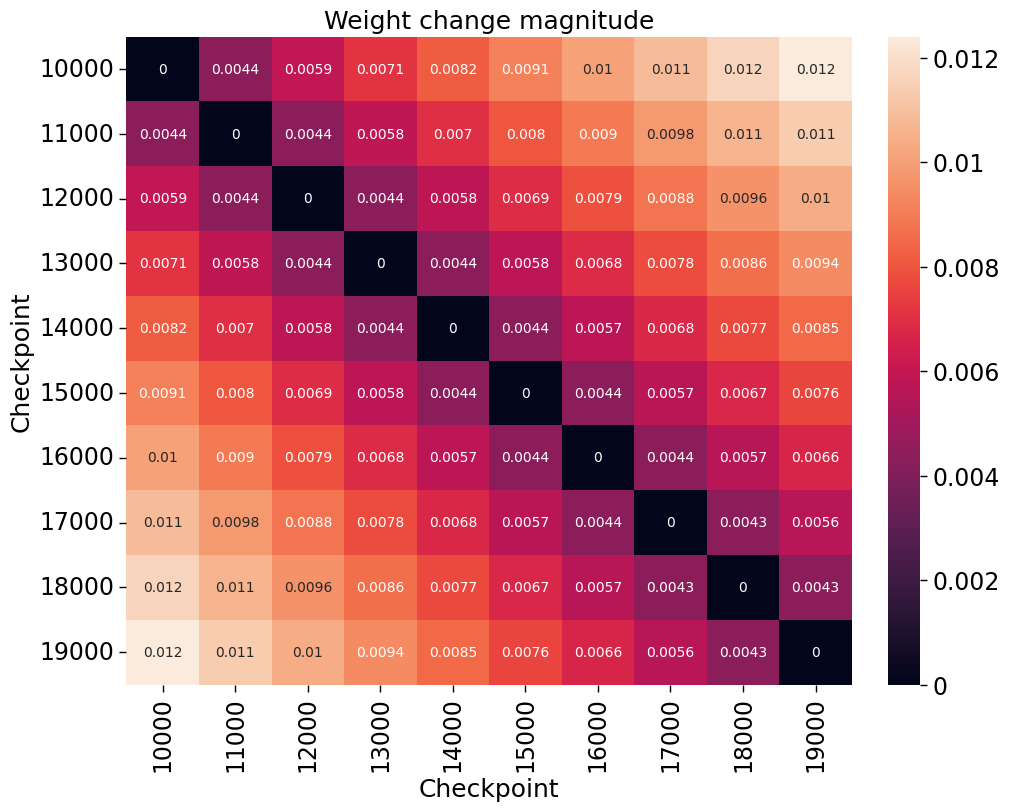

In [62]:
from matplotlib.ticker import FuncFormatter

f, ax = plt.subplots(figsize=(10, 8))
fmt = lambda x, pos: '{:.2g}'.format(x)
sns.heatmap(np.sqrt(np.array(dists).reshape(len(ckpts), len(ckpts)) / len(all_params)), annot=True, fmt='.2g', annot_kws={"fontsize":10}, xticklabels=range(10000, 20000, 1000),
           yticklabels=range(10000, 20000, 1000), cbar_kws={"format":FuncFormatter(fmt)}, ax=ax)
plt.xticks(rotation='vertical');
plt.yticks(rotation='horizontal');
ax.set(title="Weight change magnitude", xlabel="Checkpoint", ylabel="Checkpoint")
f.savefig('../figures/weight_changes.pdf')

In [63]:
np.sqrt(np.sum(np.square(torch.randn_like(all_params) * 2e-3).detach().numpy()) / len(all_params))

0.002000048484653602